In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch
from unet_lightening_checkpinter import LitUNet, UNet
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
# Link: https://albumentations.ai/docs/3-basic-usage/semantic-segmentation/ 

#### `Convert a hexadecimal color code to an RGB numpy array.`

In [2]:
# Constants
patch_size = 256
scaler = MinMaxScaler()
def hex_to_rgb(hex_code):
    """
    Convert a hexadecimal color code to an RGB numpy array.

    Args:
        hex_code (str): A string representing a color in hexadecimal format.
                        It may optionally start with a '#' character.
                        Example: '#FF5733' or 'FF5733'.

    Returns:
        np.ndarray: A numpy array of three integers representing the RGB color.
                    Each integer ranges from 0 to 255, corresponding to red, green,
                    and blue channels respectively.

    Example:
        >>> hex_to_rgb('#FF5733')
        array([255,  87,  51])
    """
    hex_code = hex_code.lstrip('#')
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))



#### `Convert a 3-channel RGB label image into a 2D array of class indices.`

In [3]:
COLOR_MAP = {
    0: hex_to_rgb('#3C1098'),  # Building
    1: hex_to_rgb('#8429F6'),  # Land
    2: hex_to_rgb('#6EC1E4'),  # Road
    3: hex_to_rgb('FEDD3A'),   # Vegetation
    4: hex_to_rgb('E2A929'),   # Water
    5: hex_to_rgb('#9B9B9B')   # Unlabeled
}

def rgb_to_2D_label(label):
    """
    Convert a 3-channel RGB label image into a 2D array of class indices.

    Each pixel's RGB color is matched against a predefined color map (`COLOR_MAP`),
    and the corresponding class index is assigned in the output 2D label array.

    Args:
        label (np.ndarray): A 3D numpy array of shape (H, W, 3) representing
                            an RGB image where each pixel's color corresponds to
                            a class as defined in `COLOR_MAP`.

    Returns:
        np.ndarray: A 2D numpy array of shape (H, W) with dtype uint8, where
                    each element is the class index corresponding to the pixel's
                    color in the input label.

    Notes:
        - The function assumes that every pixel's color in `label` matches
          exactly one of the RGB colors in `COLOR_MAP`.
        - `COLOR_MAP` should be a dictionary mapping class indices (int) to
          RGB numpy arrays of shape (3,) representing the color.

    Example:
        >>> label_rgb = np.array([[[60, 16, 152], [132, 41, 246]],
                                  [[110, 193, 228], [254, 221, 58]]], dtype=np.uint8)
        >>> rgb_to_2D_label(label_rgb)
        array([[0, 1],
               [2, 3]], dtype=uint8)
    """
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        matches = np.all(label == v, axis=-1)
        label_seg[matches] = k
    return label_seg


#### `A PyTorch Dataset for loading and patchifying images and their corresponding segmentation masks.`

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_patches = []
        self.mask_patches = []
        self.transform = transform or self.default_transform()
        self._prepare_data()

    def default_transform(self):
        return A.Compose([
            A.Resize(patch_size, patch_size),
            A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # adjust if needed
        ])

    def _prepare_data(self):
        for idx, row in self.df.iterrows():
            img = cv2.imread(row['Image'])
            mask = cv2.imread(row['Mask'])
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            h, w = img.shape[:2]
            crop_w = (w // patch_size) * patch_size
            crop_h = (h // patch_size) * patch_size
            img = img[:crop_h, :crop_w]
            mask = mask[:crop_h, :crop_w]

            img_patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
            mask_patches = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for i in range(img_patches.shape[0]):
                for j in range(img_patches.shape[1]):
                    img_patch = img_patches[i, j, 0]
                    mask_patch = mask_patches[i, j, 0]

                    transformed = self.transform(image=img_patch, mask=mask_patch)
                    img_patch_aug = transformed['image']
                    mask_patch_aug = transformed['mask']
                    mask_patch_aug = rgb_to_2D_label(mask_patch_aug)

                    self.image_patches.append(img_patch_aug)
                    self.mask_patches.append(mask_patch_aug)

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = torch.tensor(self.image_patches[idx], dtype=torch.float32).permute(2, 0, 1)  # (3,H,W)
        mask = torch.tensor(self.mask_patches[idx], dtype=torch.long)  # (H,W)
        return image, mask


#### `Using ModelCheckpoint.`

In [5]:
# ------------------------
# DataModule
# ------------------------
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, train_csv, test_csv, batch_size=16):
        super().__init__()
        self.train_csv = train_csv
        self.test_csv = test_csv
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.train_csv)
        self.val_dataset = SegmentationDataset(self.test_csv)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

# ------------------------
# Training Function
# ------------------------

def get_latest_checkpoint(checkpoint_dir='checkpoints/'):
    ckpts = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))
    if not ckpts:
        return None
    latest_ckpt = max(ckpts, key=os.path.getctime)
    return latest_ckpt

def main(resume_checkpoint=None):
    data_module = SegmentationDataModule('train.csv', 'test.csv', batch_size=16)
    data_module.setup()

    all_masks = torch.cat([mask.flatten() for _, mask in data_module.train_dataset])
    n_classes = 6  # fix this if known
    in_channels = 3  # fix if RGB input

    model = LitUNet(n_classes=n_classes, in_channels=in_channels, lr=1e-3)

    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints/',
        filename='unet-{epoch:02d}-{val_loss:.4f}',
        save_top_k=1,
        monitor='val_loss',
        mode='min'
    )

    # If no checkpoint provided, get the latest one automatically
    if resume_checkpoint is None:
        resume_checkpoint = get_latest_checkpoint()

    trainer = pl.Trainer(
        max_epochs=2,
        accelerator='auto',
        callbacks=[checkpoint_callback],
    )

    trainer.fit(model, datamodule=data_module, ckpt_path=resume_checkpoint)

    print(f"Best model saved at: {checkpoint_callback.best_model_path}")
    return checkpoint_callback.best_model_path


# ------------------------
# Validation Function
# ------------------------
def validate_or_predict(checkpoint_path, test_csv='test.csv'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load full model from checkpoint (hparams restored automatically)
    model = LitUNet.load_from_checkpoint(checkpoint_path)
    model.to(device)
    model.eval()

    test_dataset = SegmentationDataset(test_csv)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    for images, masks in test_loader:
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
        print(f'Predicted batch shape: {preds.shape}')
        break


# ------------------------
# Entry Point
# ------------------------
if __name__ == '__main__':
    best_checkpoint = main()
    validate_or_predict(best_checkpoint)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/soumendusekharbhattacharjee/anaconda3/envs/unet_pytorch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/soumendusekharbhattacharjee/Documents/DATA-SCIENCE/Kaushik/satelite_image/lightning/code/checkpoints exists and is not empty.
Restoring states from the checkpoint path at checkpoints/unet-epoch=01-val_loss=0.7904.ckpt

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | UNet             | 1.9 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.765     Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at check

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/soumendusekharbhattacharjee/anaconda3/envs/unet_pytorch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/soumendusekharbhattacharjee/anaconda3/envs/unet_pytorch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=2` reached.


Best model saved at: /Users/soumendusekharbhattacharjee/Documents/DATA-SCIENCE/Kaushik/satelite_image/lightning/code/checkpoints/unet-epoch=01-val_loss=0.7904.ckpt
Predicted batch shape: torch.Size([16, 256, 256])


#### `Save the state dictionary of a trained PyTorch model to disk.`

In [6]:
def save_trained_model(model, filepath="unet_model.pth"):
    """
    Save the state dictionary of a trained PyTorch model to disk.

    Args:
        model (torch.nn.Module): The trained PyTorch model whose parameters are to be saved.
        filepath (str, optional): The path where the model state dict will be saved.
                                  Defaults to "unet_model.pth".

    Returns:
        None
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")



#### `Plot training and validation loss over epochs from PyTorch Lightning logs.`

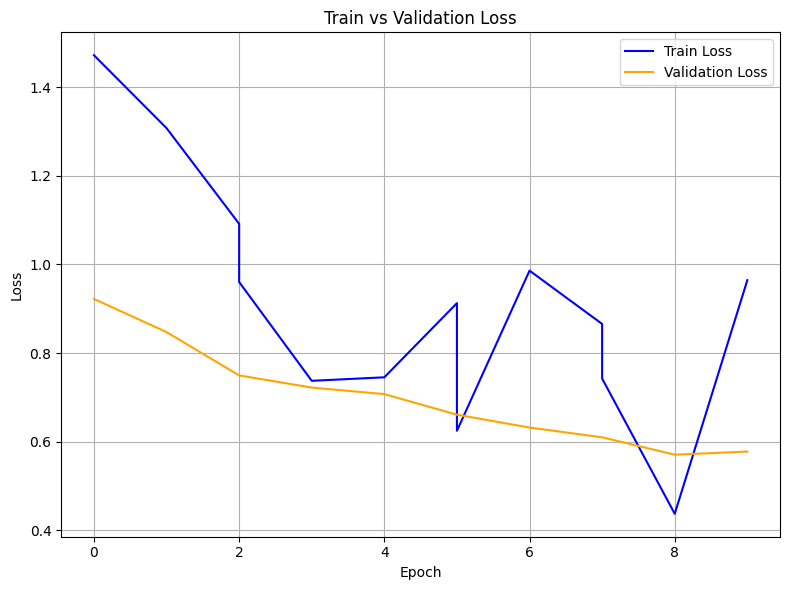

In [7]:
"""
Plot training and validation loss over epochs from PyTorch Lightning logs.

This script reads the `metrics.csv` file generated by PyTorch Lightning during model training, 
extracts the training and validation loss values while removing rows with missing data (NaNs), 
and visualizes the loss trends over epochs using matplotlib.

Steps:
1. Load the metrics CSV from the specified log directory.
2. Filter and clean the training and validation loss columns.
3. Plot both losses against epochs for comparison.

Useful for monitoring model performance and detecting overfitting or underfitting.
"""

# Load metrics
df_v1 = pd.read_csv("lightning_logs/version_1/metrics.csv")

# Drop rows with NaNs in the relevant columns
train_loss = df_v1[["epoch", "train_loss"]].dropna()
val_loss = df_v1[["epoch", "val_loss"]].dropna()

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss["epoch"], train_loss["train_loss"], label="Train Loss", color="blue")
plt.plot(val_loss["epoch"], val_loss["val_loss"], label="Validation Loss", color="orange")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### `Visualize training and validation Jaccard scores over epochs from PyTorch Lightning logs.`

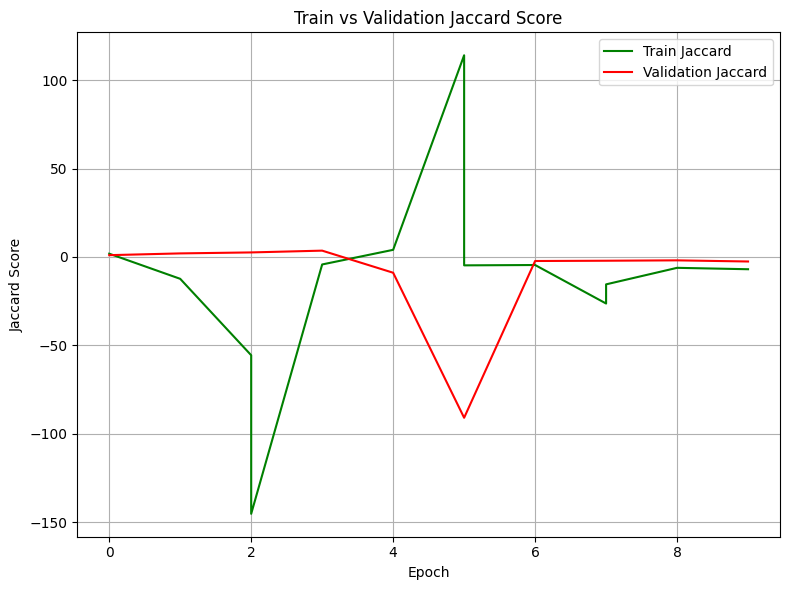

In [8]:
"""
Visualize training and validation Jaccard scores over epochs from PyTorch Lightning logs.

This script performs the following steps:
1. Loads the `metrics.csv` file generated by PyTorch Lightning during training.
2. Extracts and cleans the `train_jaccard` and `val_jaccard` columns by dropping rows with missing values (NaNs).
3. Plots the Jaccard score progression for both training and validation sets against training epochs.

The Jaccard score (also known as Intersection over Union) is commonly used for evaluating 
segmentation model performance. This plot helps track model accuracy and detect overfitting or underfitting trends.
"""

# Load metrics
df_v1 = pd.read_csv("lightning_logs/version_1/metrics.csv")

# Drop rows with NaNs in the relevant columns
train_jaccard = df_v1[["epoch", "train_jaccard"]].dropna()
val_jaccard = df_v1[["epoch", "val_jaccard"]].dropna()

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_jaccard["epoch"], train_jaccard["train_jaccard"], label="Train Jaccard", color="green")
plt.plot(val_jaccard["epoch"], val_jaccard["val_jaccard"], label="Validation Jaccard", color="red")
plt.title("Train vs Validation Jaccard Score")
plt.xlabel("Epoch")
plt.ylabel("Jaccard Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### `Semantic Segmentation Inference and Visualization using a PyTorch Lightning UNet Model.`

Using device: mps


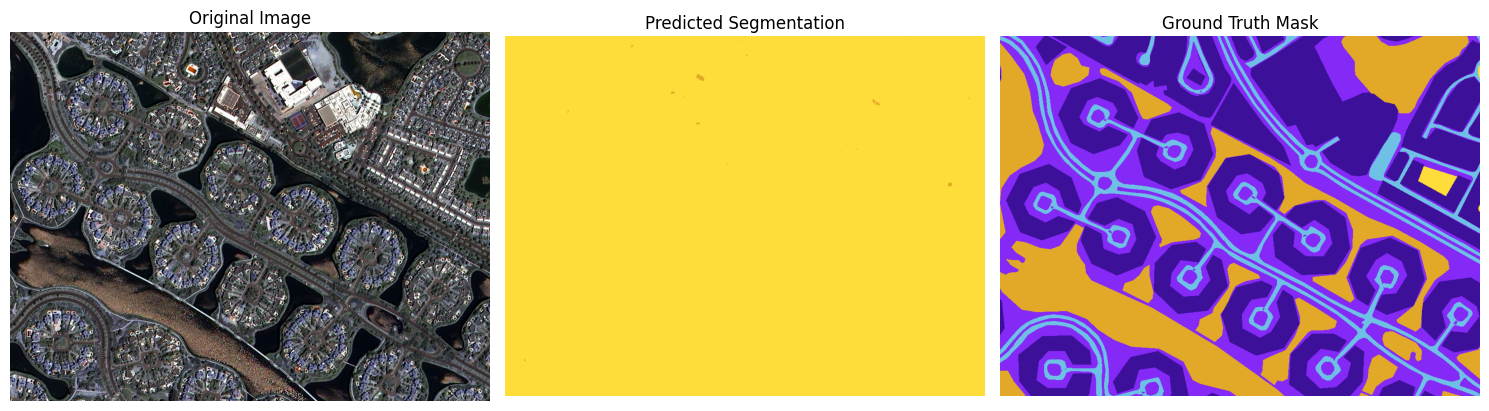

In [9]:
"""
Semantic Segmentation Inference and Visualization using a PyTorch Lightning UNet Model

This script performs the following tasks:
1. Defines helper functions for handling RGB label maps:
   - `hex_to_rgb`: Converts hex color codes to RGB tuples.
   - `rgb_to_2D_label`: Converts RGB segmentation masks to class label indices.
   - `label_to_rgb`: Converts class label indices back to RGB images for visualization.

2. Implements a minimal UNet model (`UNet`) and wraps it with a PyTorch Lightning module (`LitUNet`).

3. The `LitUNet` class includes a `predict_and_visualize` method that:
   - Loads an input image and its corresponding ground truth mask.
   - Preprocesses and feeds the image through the trained model.
   - Generates the predicted segmentation mask.
   - Displays the original image, predicted segmentation, and ground truth side-by-side using matplotlib.

4. In the `__main__` block:
   - Loads the test dataset paths from `test.csv`.
   - Loads a trained model from `unet_model.pth`.
   - Selects a sample from the dataset and visualizes the segmentation result.

Usage:
- Make sure `test.csv` contains columns: `Image` and `Mask` with valid file paths.
- Ensure `unet_model.pth` is a valid trained model checkpoint.
- Modify `sample_idx` to visualize different samples from the test set.

Supported classes:
0: Building, 1: Land, 2: Road, 3: Vegetation, 4: Water, 5: Unlabeled
"""

# --- Color map helpers ---
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

COLOR_MAP = {
    0: hex_to_rgb('#3C1098'),  # Building
    1: hex_to_rgb('#8429F6'),  # Land
    2: hex_to_rgb('#6EC1E4'),  # Road
    3: hex_to_rgb('FEDD3A'),   # Vegetation
    4: hex_to_rgb('E2A929'),   # Water
    5: hex_to_rgb('#9B9B9B')   # Unlabeled
}

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        matches = np.all(label == v, axis=-1)
        label_seg[matches] = k
    return label_seg

def label_to_rgb(label_2d):
    rgb_img = np.zeros((label_2d.shape[0], label_2d.shape[1], 3), dtype=np.uint8)
    for k, v in COLOR_MAP.items():
        rgb_img[label_2d == k] = v
    return rgb_img

# --- Your UNet model definition ---
class UNet(torch.nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super().__init__()
        # Replace with your actual UNet implementation
        self.conv = torch.nn.Conv2d(in_channels, n_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# --- Lightning module wrapping UNet ---
class LitUNet(pl.LightningModule):
    def __init__(self, n_classes=6, in_channels=3):
        super().__init__()
        self.n_classes = n_classes
        self.in_channels = in_channels
        self.model = UNet(n_classes=n_classes, in_channels=in_channels)

    def forward(self, x):
        return self.model(x)

    def predict_and_visualize(self, image_path, mask_path, patch_size=256, device=None):
        device = device or next(self.parameters()).device
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_crop = Image.fromarray(img_rgb).crop(
            (0, 0, (img.shape[1] // patch_size) * patch_size, (img.shape[0] // patch_size) * patch_size)
        )
        img_np = np.array(img_crop)

        img_norm = img_np / 255.0
        img_tensor = torch.tensor(img_norm, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        self.eval()
        with torch.no_grad():
            output = self(img_tensor)
            predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        gt_mask = cv2.imread(mask_path)
        gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
        gt_crop = Image.fromarray(gt_mask).crop(
            (0, 0, (gt_mask.shape[1] // patch_size) * patch_size, (gt_mask.shape[0] // patch_size) * patch_size)
        )
        gt_mask_np = np.array(gt_crop)
        gt_label = rgb_to_2D_label(gt_mask_np)

        pred_rgb = label_to_rgb(predicted_mask)
        gt_rgb = label_to_rgb(gt_label)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_rgb)
        plt.title("Predicted Segmentation")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load test.csv dataset
    test_df = pd.read_csv('test.csv')

    n_classes = 6
    in_channels = 3

    model = LitUNet(n_classes=n_classes, in_channels=in_channels)
    model.load_state_dict(torch.load('unet_model.pth', map_location=device))
    model.to(device)

    sample_idx = 1  # change this to visualize different test samples
    image_path = test_df.iloc[sample_idx]['Image']
    mask_path = test_df.iloc[sample_idx]['Mask']

    model.predict_and_visualize(image_path, mask_path, patch_size=256, device=device)
